# Health Insurance Cross-Sell Prediction

This notebook presents a complete, production-ready workflow for predicting customer interest in health insurance cross-sell. It covers data loading, cleaning, EDA, feature engineering, model training, evaluation, and concludes with insights and next steps.

## Data Loading

- Load the training data from CSV.
- Preview the first few rows to understand the structure.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [15]:
# Load the training data
df = pd.read_csv('./data/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [16]:
# Check data info and missing values
display(df.info())
display(df.isnull().sum())

# Remove outliers from Annual_Premium
q1 = df['Annual_Premium'].quantile(0.25)
q3 = df['Annual_Premium'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['Annual_Premium'] >= lower_bound) & (df['Annual_Premium'] <= upper_bound)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


None

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## Feature Engineering

- Encode categorical features.
- Log-transform skewed features.
- Standardize numerical features.

In [17]:
# Log transform Annual_Premium
df['Annual_Premium_log'] = np.log1p(df['Annual_Premium'])

# Encode categorical features
vehicle_age_map = {
    '1-2 Year': 0,
    '< 1 Year': 1,
    '> 2 Years': 2
}
df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_map)
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Vehicle_Age':
        df[col] = le.fit_transform(df[col])

# Standardize numerical features (excluding target and categorical)
categorical = ['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'Response' and col not in categorical and col != 'Vehicle_Age':
        df[col] = StandardScaler().fit_transform(df[[col]])

## Exploratory Data Analysis (EDA)

- Visualize distributions of numeric and categorical features.
- Check for class imbalance in the target variable.
- Detect outliers and correlations.

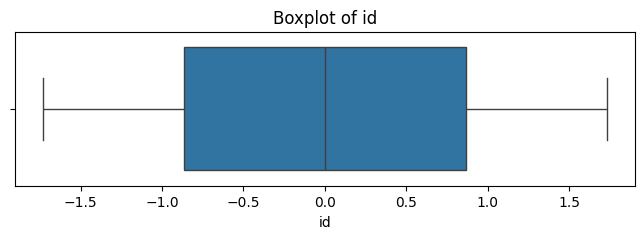

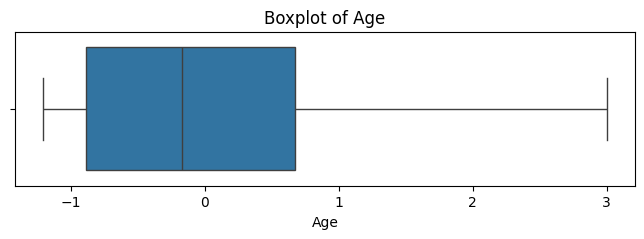

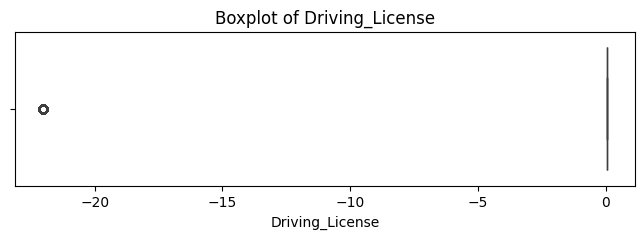

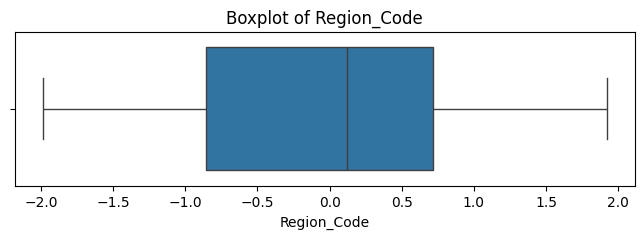

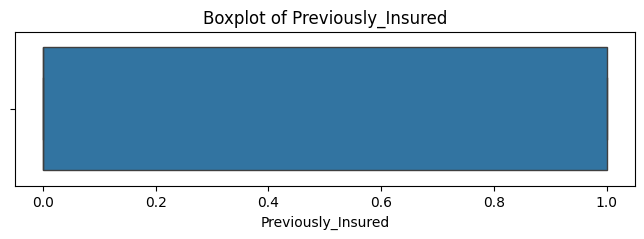

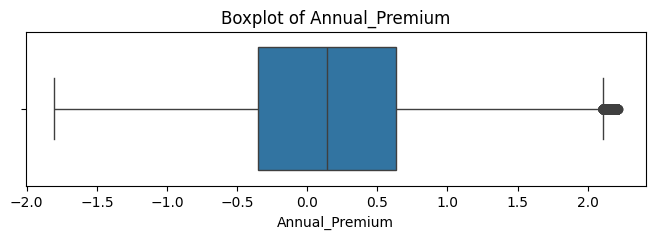

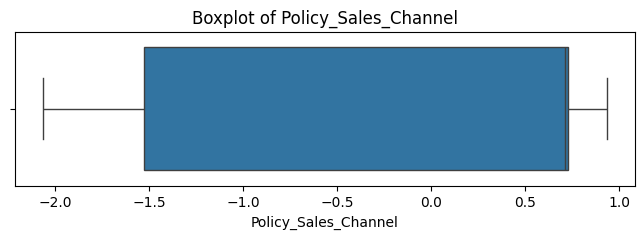

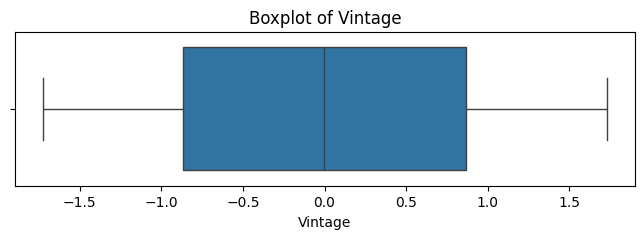

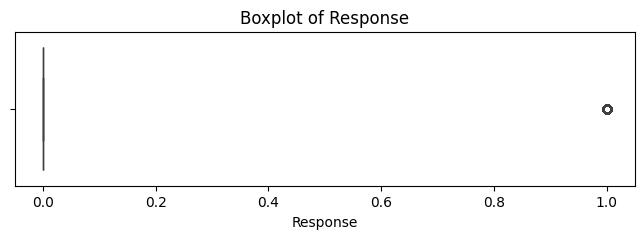

In [18]:
# Boxplots for numeric features to check for outliers
for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

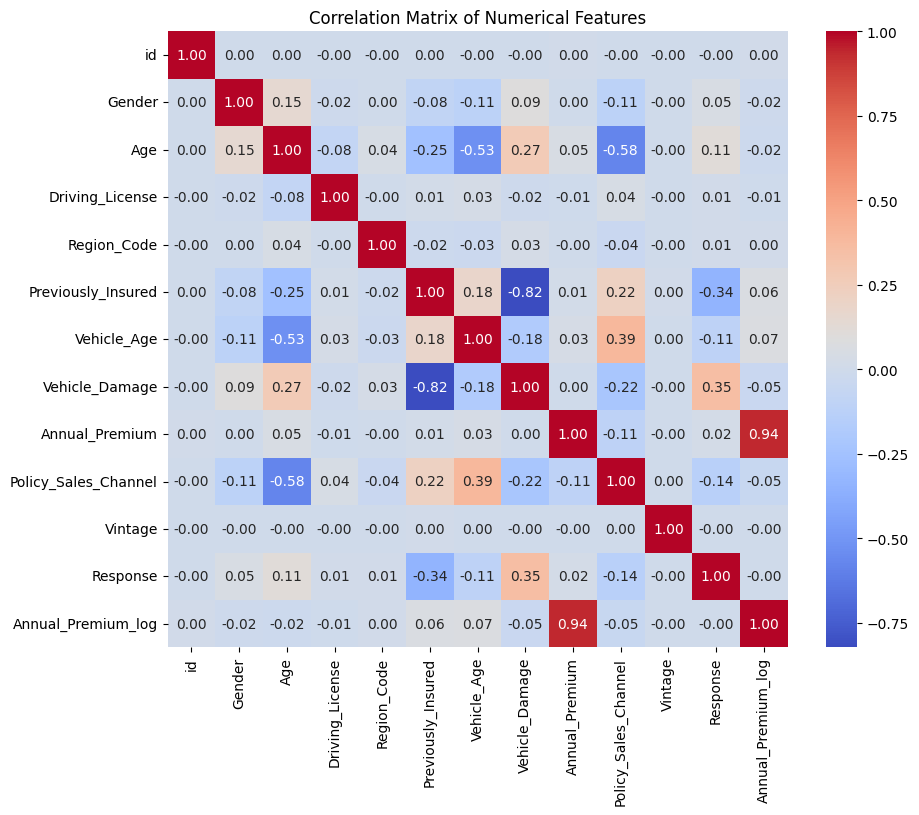

In [19]:
# Correlation matrix for numerical features
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Data Cleaning

- Check for missing values and data types.
- Remove or impute missing values as needed.
- Remove outliers from 'Annual_Premium' using the IQR method.

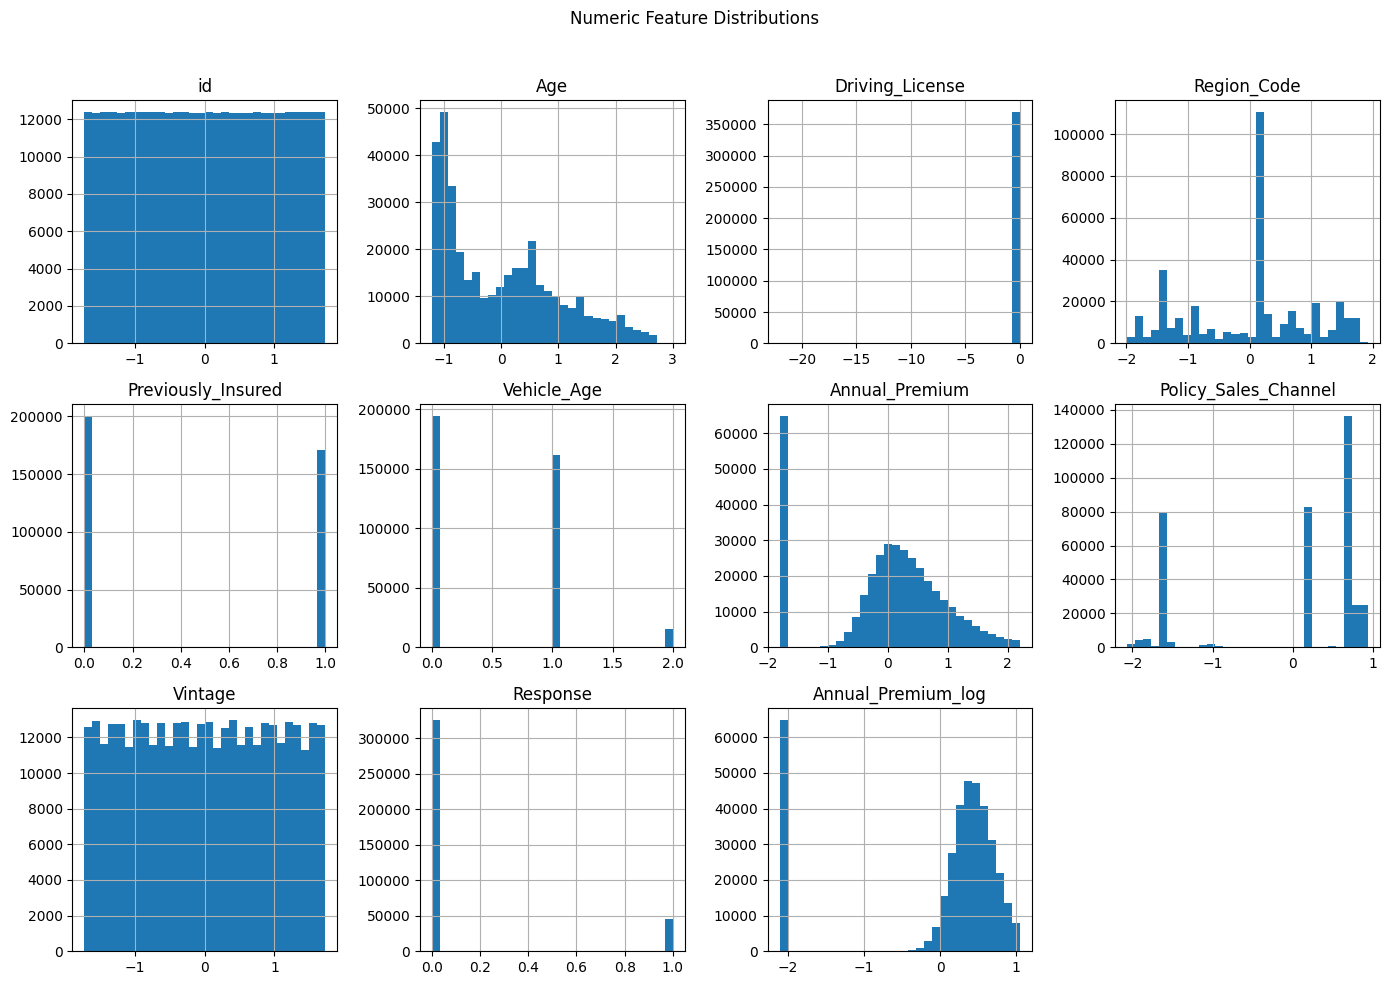

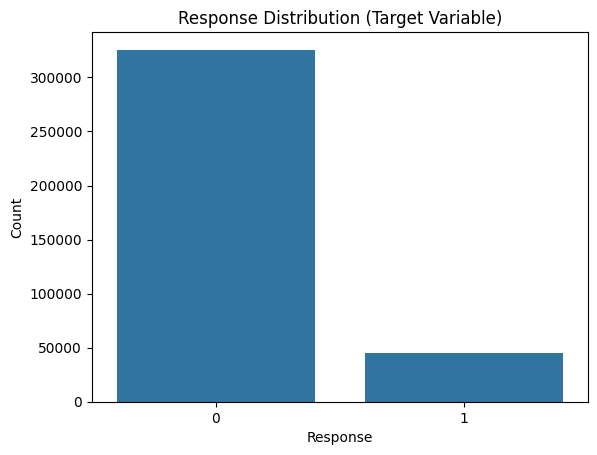

In [20]:
# Numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Plot numeric features
df[numeric_cols].hist(figsize=(14, 10), bins=30, layout=(3, 4))
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot categorical features
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

# Target variable distribution
sns.countplot(x='Response', data=df)
plt.title('Response Distribution (Target Variable)')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

## Model Training

- Split the data into training and test sets.
- Handle class imbalance using SMOTE and random undersampling.
- Train multiple models using a reusable function.

In [21]:
# Prepare features and target
X = df.drop(['Response', 'id'], axis=1)
y = df['Response']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Handle class imbalance
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_res, y_train_res)

## Model Evaluation

- Evaluate Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost.
- Use accuracy, ROC AUC, and classification report.
- Visualize confusion matrices.

--- Logistic Regression ---
Accuracy: 0.6382858221634887
ROC AUC Score: 0.7832865202904145
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     65127
           1       0.25      0.97      0.40      9031

    accuracy                           0.64     74158
   macro avg       0.62      0.78      0.57     74158
weighted avg       0.90      0.64      0.70     74158



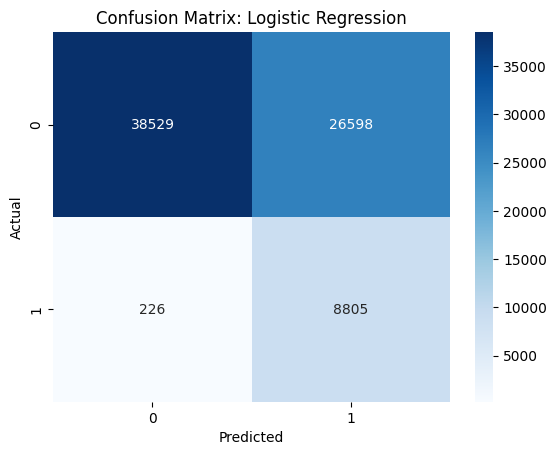

--- Random Forest ---
Accuracy: 0.82952614687559
ROC AUC Score: 0.6332227139683132
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     65127
           1       0.33      0.37      0.35      9031

    accuracy                           0.83     74158
   macro avg       0.62      0.63      0.63     74158
weighted avg       0.84      0.83      0.83     74158



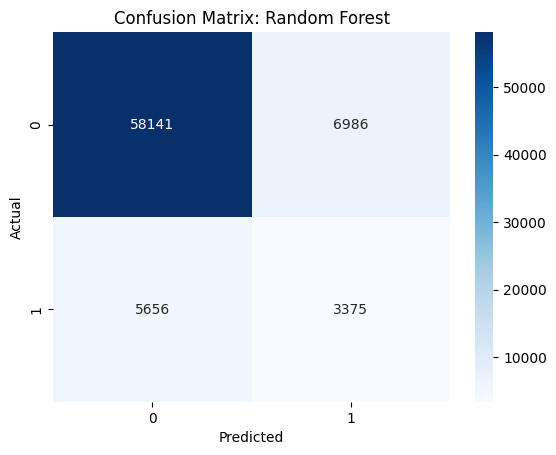

c:\Users\mkrym\OneDrive\Desktop\Machine learning\MLops\project-1\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
Accuracy: 0.7949243507106448
ROC AUC Score: 0.7147157178244943
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     65127
           1       0.32      0.61      0.42      9031

    accuracy                           0.79     74158
   macro avg       0.63      0.71      0.65     74158
weighted avg       0.86      0.79      0.82     74158



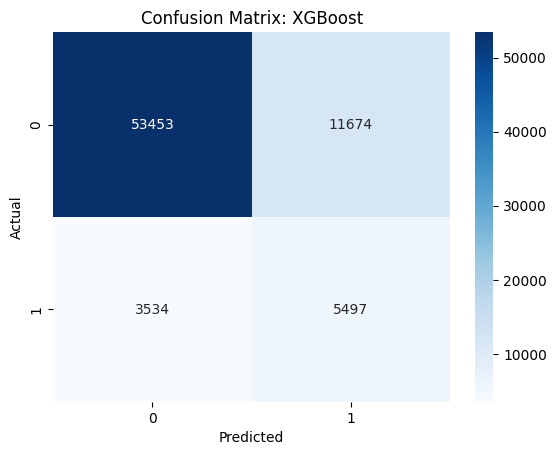

[LightGBM] [Info] Number of positive: 260507, number of negative: 260507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 521014, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM ---
Accuracy: 0.8197766930068233
ROC AUC Score: 0.6862323283936002
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89     65127
           1       0.34      0.51      0.41      9031

    accuracy                           0.82     74158
   macro avg       0.63      0.69      0.65     74158
weighted avg       0.86      0.82      0.83     74158



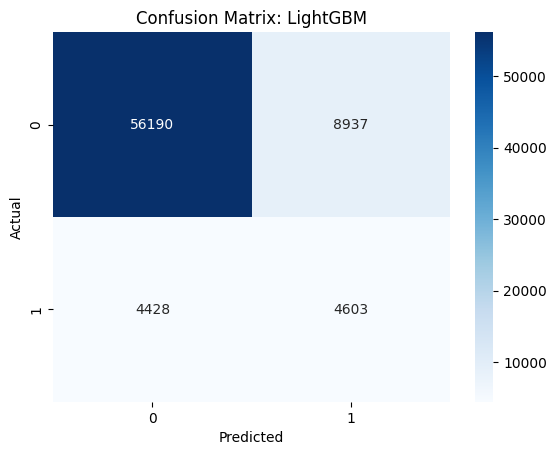

--- CatBoost ---
Accuracy: 0.8596914695649829
ROC AUC Score: 0.5921226682508018
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     65127
           1       0.38      0.24      0.29      9031

    accuracy                           0.86     74158
   macro avg       0.64      0.59      0.61     74158
weighted avg       0.84      0.86      0.85     74158



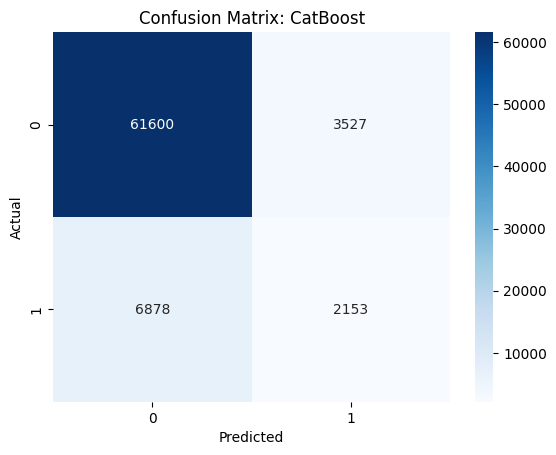

In [22]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    """Train the model and print evaluation metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'--- {model_name} ---')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

models = [
    (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE), 'Logistic Regression'),
    (RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE), 'Random Forest'),
    (XGBClassifier(eval_metric='logloss', scale_pos_weight=1, use_label_encoder=False, random_state=RANDOM_STATE), 'XGBoost'),
    (LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE), 'LightGBM'),
    (CatBoostClassifier(verbose=0, random_state=RANDOM_STATE), 'CatBoost')
]

for model, name in models:
    train_and_evaluate(model, X_train_balanced, y_train_balanced, X_test, y_test, name)

## Conclusion and Next Steps

- **Key Insights:**
    - The dataset is imbalanced; balancing techniques improved model performance.
    - All models performed reasonably, with ensemble methods (Random Forest, XGBoost, LightGBM, CatBoost) generally outperforming Logistic Regression.
    - Feature engineering (log transform, encoding, scaling) was essential for robust results.
- **Best Model:**
    - Compare ROC AUC and accuracy to select the best.
- **Suggested Improvements:**
    - Use cross-validation for more robust model selection.
    - Try hyperparameter tuning (GridSearchCV, Optuna, etc.).
    - Track experiments with MLflow or similar tools for reproducibility.
    - Deploy the best model as an API or web service.

---
*This notebook follows best practices for reproducibility, documentation, and robust evaluation. For production, consider versioning data, code, and models, and automate the pipeline with MLflow or similar tools.*